# Punctuation restoration

The sequence tagging with BERT-like models is quite common among researchers nowdays
+ For example, the following research https://www.researchgate.net/publication/348618580_Automatic_punctuation_restoration_with_BERT_models (WordPiece + BERT uncased) suggests tagging words with labes `EMPTY`, `PERIOD`, `COMMA` etc. when they are followed by a punctuation symbol or not. The minor downside of suggested approach is that they use full-fledged dictionary, which may me memory-consuming. 
+ The overlapping sliding window is suggested to deal with sentences of the size exceeding input length. Due to overelap, for the same pieces we may get several predictions. The mean of them will be taken.

First of all, in my research I'd like to concentrate on correcting commas in a sentence, so I may limit my output data to "COMMA" and "EMP" for now

1. To train the model from scratch, we have to perform conversion of BPE encoded data to a form, in which our objective would be to predict, wheither a token is followed by a comma/period.

## Step 1: common preparation of textual data

Yttm will behave nicely with text with commas, separated by space from both sides. This approach misses some information, like common word endings that are followed by a comma, yet it may be simplier to implement.

**Important**: this shall be done for every training case. At the evaluation step text shall not contain any commas

In [193]:
import youtokentome as yttm
import pandas as pd
import numpy as np
import re

In [194]:
data = pd.read_parquet("text_corpus.parquet")

In [218]:
corpus = [text.replace(",", " ,").lower() for text in data.text]

## Step 2: creating encoder
For such modified text data bpe encoder shall be trained separately, of course.

In [196]:
TOTAL_WORDS = 30000
BPE_MODEL_PATH = "bpe.yttm"
def create_bpe_tokenizer_from_scratch(corpus, train_data_path="yttm_train_data.txt"):
    with open(train_data_path, "w") as _file:
        _file.writelines(corpus)
    # Training model
    # (data, model, vocab_size, coverage, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3)
    return yttm.BPE.train(data=train_data_path, vocab_size=total_words, model=bpe_model_path)

In [ ]:
bpe = create_bpe_tokenizer_from_scratch(" \n ".join(corpus))

In [228]:
COMMA = bpe.encode(" ,")[0] # COMMA token shall be fixed after each re-training

In [220]:
print(' '.join(bpe.vocab())[:600])

<PAD> <UNK> <BOS> <EOS> ▁ о е и а н т с р в л к п д м у я ы г з б , ь ч й . х ж ' ц ю ш ф щ - э « » ъ ( ) — : – ? ” ё “   ! ; … / [ ] > < ‒ ­ + * ‘ ​ # • ̆ ‎ ` @ ‚ ’ _ \ & ️ · = ▁п ▁с ▁в ▁, ст ни ра ро но ре на ▁о ко то ▁и ▁по го не де те ли ва за ны ▁м ▁на ль ка ри та ле ла во ▁д ве ▁б ти ци ▁со ви ▁ч ки ло ▁у да ▁за ▁' ть ен ми ▁не ▁а сс ▁ко ет ру ▁пре ся ди ▁про ния ▁ра че ско ме ▁что ▁э ▁об об ▁г ▁во ▁от по сти ▁- мо ма ▁к ние ста тель ля ▁при же ▁е се ше ры ▁ре ▁го зи ▁ро сси до ▁до ер ду ции щи ных хо бо ски ной ча ▁ка ще ▁де ту га ного ну чи ▁мо ▁росси лу нии су па ▁то сто ▁ми ▁ф ▁вы ▁с


## Step 3: comma encoding algorithm

Now as we have a way to create a numerical representation of our textual data, we have to process it in a way to 
1. Remove all commas (our model shall not know where they are originally, just try to predict)
2. Save information about commas in a way we will be able to calculate loss between a model's prediction and actual data.

In short, our algorithm will be the following:
1. At the position of each word followed by a comma we will put label 1
2. The following comma token will be stripped out
3. At the end, lengthes of encoded sentence and label list shall be equal.

In [247]:
def encode_commas(sent):
    # for-loopish version can be optimized
    result = []
    for idx, token in enumerate(sent):
        if idx == len(sent) - 1:
            # no comma checking for last token
            result.append(0)
        else:
            if token == COMMA:
                continue
            elif sent[idx+1] == COMMA:
                result.append(1)
            else:
                result.append(0)
    assert sum(result) > 0, "Sentence MUST contain at least 1 comma"
    return result

## Step 4: creating train data


1. Encode a sentence
2. Encode commas
3. Strip commas from encoded sentence
4. Ensure lengthes are equal

In [204]:
# sentences for now are just by splitting by period
# also we dont need sents without commas
corpus_of_sents_with_commas = [ sent.strip() 
                               for text in corpus 
                               for sent in text.split(".") 
                               if "," in sent 
                               and len(sent) > 15 ]

In [267]:
encoded_corpus = []
tags = []
for idx, sent in enumerate(corpus_of_sents_with_commas):
    encoded_sentence = bpe.encode(sent)
    if not COMMA in encoded_sentence:
        continue
    if encoded_sentence[0] == COMMA: # issue of period separation
        continue
    taglist = encode_commas(encoded_sentence)
    encoded_sentence = list(filter(lambda x: x != COMMA, encoded_sentence))
    es_len = len(encoded_sentence)
    tl_len = len(taglist)
    if es_len != tl_len:
        print(f"Lengthes do not match at {idx}: sentence has {es_len} and taglist has {tl_len}")
        continue
    encoded_corpus.append(encoded_sentence)
    tags.append(taglist)

Lengthes do not match at 27196: sentence has 19 and taglist has 20
Lengthes do not match at 44791: sentence has 28 and taglist has 29
Lengthes do not match at 46328: sentence has 28 and taglist has 29
Lengthes do not match at 62664: sentence has 15 and taglist has 16
Lengthes do not match at 77385: sentence has 22 and taglist has 23
Lengthes do not match at 100192: sentence has 28 and taglist has 29
Lengthes do not match at 102759: sentence has 34 and taglist has 35
Lengthes do not match at 109407: sentence has 17 and taglist has 18
Lengthes do not match at 131586: sentence has 23 and taglist has 24
Lengthes do not match at 142921: sentence has 25 and taglist has 26
Lengthes do not match at 144235: sentence has 25 and taglist has 26
Lengthes do not match at 193790: sentence has 11 and taglist has 12
Lengthes do not match at 196326: sentence has 17 and taglist has 18
Lengthes do not match at 217702: sentence has 16 and taglist has 17


In [269]:
len(encoded_corpus)

225488

In [268]:
assert len(tags) == len(encoded_corpus)

## Step 5: creating model

In [259]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [260]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = total_words
TAGSET_SIZE   = len(target_mapping)

In [261]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [270]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

In [271]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

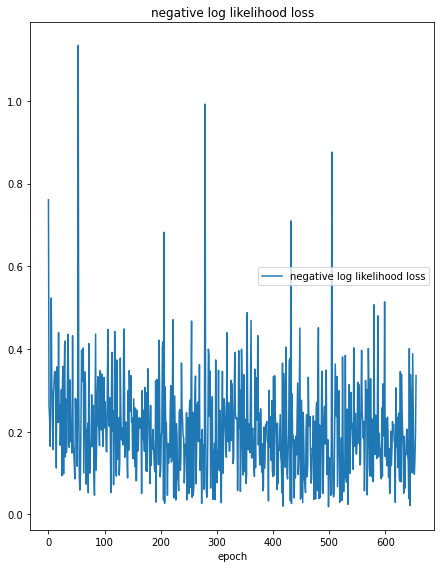

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.019, max:    1.134, cur:    0.335)


In [ ]:
for epoch in range(10): 
    for i, (text, taglist) in enumerate(zip(encoded_corpus, tags)):
        
        model.zero_grad()
        text = torch.tensor(text)
        taglist = torch.tensor(taglist)
#         print(text, labels)
#         break
        tag_scores = model(text)

        loss = loss_function(tag_scores, taglist)
        loss.backward()
        optimizer.step()
        
        
#         print(loss)
#         print(type(loss.detach().numpy()))
#         break
        if i % 1000 == 0:
            l = loss.detach().numpy()
            liveplot.update({'negative log likelihood loss': l})
            liveplot.draw()
            
            
#         if i == 15000:
#             break

## Step 6: evaluation and inverse transformation

Now when we have a model predicting commas for us, it would be useful to inject those predictions right into our sentence.

In [ ]:
def fill_in_commas(text):
    # ensure text has no commas
    text = text.replace(",", "")
    # ensure text accidentaly has no spaces in a row
    text = re.sub("\s{2,}", " ", text)
    # encode text by bpe
    encoded_text = bpe.encode(text)
    # get predicted labels
    predicted_tags = modek.predict_tags(encoded_text)
    # inject commas
    result = []
    for token, label in zip(encoded_text, predicted_tags):
        result.append(token)
        if label:
            result.append(COMMA)
    return bpe.decode(result)
    